In [1]:
import os
import json


## Model setup

In [2]:
from langchain_ollama import ChatOllama

MODEL_NAME = "qwen2.5:latest"
SUBSET = "car_1"

llm = ChatOllama(
    model=MODEL_NAME,
    temperature=0
)

## SQL Database Setup

In [3]:
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

DATA_DIR = "data/spider_data/spider_data/"
DATABASE_DIR = "database/"
SUBSET_DIR = SUBSET
SUBSET_FILE = f"{SUBSET}.sqlite"
DATABASE_PATH = os.path.join(DATA_DIR, DATABASE_DIR, SUBSET_DIR, SUBSET_FILE)
DEV_JSON = os.path.join(DATA_DIR, "dev.json")
json_data = None
FILTER_LIST = [f"{SUBSET}"]

with open(DEV_JSON, "r") as f:
    json_data = json.load(f)

print("length of json: {}".format(len(json_data)))
# filter the training file to the database we are interested in.
dev_data = [d for d in json_data if d['db_id'] in FILTER_LIST]
print("number of training examples: {}\n".format(len(dev_data)))

# create the db from sqlite file
db = SQLDatabase.from_uri("sqlite:///{}".format(DATABASE_PATH))
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()


length of json: 1034
number of training examples: 92



In [4]:
from langgraph.graph import MessagesState
# Custom State
class SQLState(MessagesState):
    test_query: str
    test_result: str
    final_query: str
    final_result: str
    rewrite: int

In [ ]:
from typing import Literal

from langchain.messages import AIMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.config import get_stream_writer  

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")

def init_node(state: SQLState):
    return {"test_result": "", "test_query": "", "final_query": "", "final_result": "", "rewrite": 0}

# Example: create a predetermined tool call
def list_tables(state: SQLState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}

# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=200,
)


def generate_query(state: SQLState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }

    result = None
    # check if last message is a ToolMessage, and name is sql_db_query (query result)
    last_message = state["messages"][-1]
    if isinstance(last_message, ToolMessage):
        if last_message.name == "sql_db_query":
            result = last_message.content
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    if result:
        return {"messages": [response], "test_result": result}
    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: SQLState):

    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }
    # db_query..
    db_query = None

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id
    
    tool_name = tool_call["name"]
    if tool_name == "sql_db_query":
        args = tool_call["args"]
        db_query = args["query"]

    if db_query:
        return {"messages": [response], "test_query": db_query, "rewrite": state["rewrite"] + 1}
    return {"messages": [response], "rewrite": state["rewrite"] + 1}

def prepare_results(state: SQLState):
    # in order to have a clean way to get the results and query...
    return {"final_result": state["test_result"], "final_query": state["test_query"]}

def should_continue(state: SQLState) -> Literal["prepare_results", "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls or state["rewrite"] > 3:
        return "prepare_results"
    else:
        return "check_query"

In [6]:
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(SQLState)
builder.add_node(init_node)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")
builder.add_node(prepare_results, "prepare_results")

builder.add_edge(START, "init_node")
builder.add_edge("init_node", "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_edge("prepare_results", END)

builder.add_conditional_edges(
    "generate_query",
    should_continue, {
        "prepare_results": "prepare_results",
        "check_query": "check_query"

    }
)

builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

checkpointer = InMemorySaver() 
agent = builder.compile(checkpointer=checkpointer)

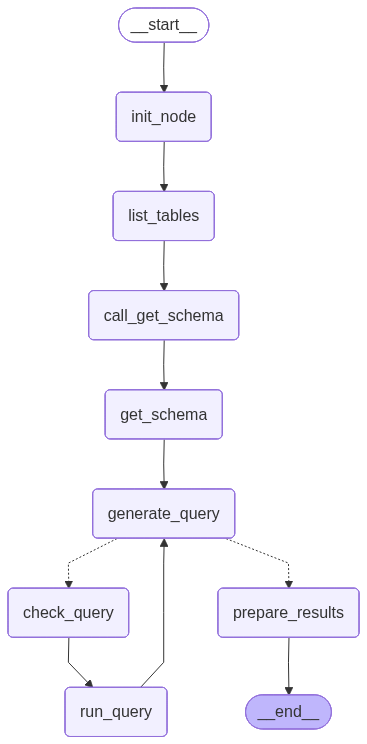

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [8]:
# example = train_data[0]
# question = example["question"]
# gold_query = example["query"]
# gold_answer = run_query_tool.run(gold_query)
# print("Question: {}\n Gold Query: {}\n Gold Answer: {}\n".format(question, gold_query, gold_answer))

In [9]:
# compare Gold SQL to Predicted SQL and Gold Answer to Returned Result
def check_execution_accuracy(gt_answer, pred_answer):
    if gt_answer == pred_answer:
        return 1
    return 0

# extract and return query and result from agent response
def extract_pred(result):
    return result["final_query"], result["final_result"]

def save_messages(result, directory, id):
    messages_str = []
    messages = result["messages"]
    for m in messages:
        messages_str.append("{}: {}".format(m.type, m.content))

    with open(os.path.join(directory, "conversation.txt"), "a") as f:
        f.write("\n\n================= instance: {} ===================\n\n".format(id))
        for m in messages_str:
            f.write(f"{m}\n")

In [10]:
# config = {"configurable": {"thread_id": "1"}}

# for step in agent.stream(
#     {"messages": [{"role": "user", "content": question}]},
#     config=config,
#     stream_mode=["updates"],
# ):
#     print(step)
#     #step["messages"][-1].pretty_print()

In [11]:
answer_pairs = []
query_pairs = []

SAVE_DIR = os.path.join("results", MODEL_NAME, "dev_{}".format(SUBSET_DIR))

os.makedirs(SAVE_DIR, exist_ok=True)

with open(os.path.join(SAVE_DIR, "execution_acc_{}_dev.txt".format(SUBSET_DIR)), "w") as f:
    for i, example in enumerate(dev_data):
        config = {"configurable": {"thread_id": "{}".format(i)}}
        question = example["question"]
        gold_query = example["query"]
        gold_answer = run_query_tool.run(gold_query)
        result = agent.invoke({"messages": [{"role": "user", "content": question}]}, config=config)
        pred_query, pred_answer = extract_pred(result)
        save_messages(result, SAVE_DIR, i)
        answer_pairs.append((gold_answer, pred_answer))
        query_pairs.append((gold_query, pred_query))
    total_correct = 0
    acc = 0.0
    for gt, pred in answer_pairs:
        total_correct += check_execution_accuracy(gt, pred)
    acc = total_correct / len(answer_pairs)
    f.write(f"Execution Accuracy: {SUBSET_DIR} \n Total Count: {len(answer_pairs)} \n Acc: {acc}\n")

with open(os.path.join(SAVE_DIR, "gold.txt"), "w") as f:
    for gt, _ in query_pairs:
        f.write("{}\t{}\n".format(gt, SUBSET_DIR))

with open(os.path.join(SAVE_DIR, "pred.txt"), "w") as f:
    for _, pred in query_pairs:
        if not pred:
            pred = "None"
        f.write("{}\n".format(pred))
